In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from MC_methods import first_visit_mc_policy_evaluation

# Blackjack

The object of the popular casino card game of *blackjack* is to obtain cards the sum of whose numerical values is as great as possible without exceeding 21. All face cards count as 10, and an ace can count either as 1 or as 11. The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw. If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goe bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21.

Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, 1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero, and we do not discount ($\gamma$ = 1); therefore these terminal rewards are also the returns. The player’s actions are to hit or to stick. The states depend on the player’s cards and the dealer’s showing card. We assume that cards are dealt from an infinite deck (i.e., with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that he could count as 11 without going bust, then the ace is said to be usable. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: his current sum (12–21), the dealer’s one showing card (ace–10), and whether or not he holds a usable ace.

Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.

In [2]:
# Create states and policy
states = []
for sum_player in range(12, 22):
    for sum_dealer in range(1, 11):
        for usable_ace in [True, False]:
            state = (sum_player, sum_dealer, usable_ace)
            states.append(state)

ACTIONS = ['hits', 'sticks']
policy = {}
for s in states:
    if s[0] >= 20:
        policy[s] = ACTIONS[1]
    else:
        policy[s] = ACTIONS[0]

In [3]:
# Create the function to generate an episoed: a list of (state, action, reward)
def generate_episode_blackjack(policy: dict):
    """
    Returns:
        episode: a list of (state, action, reward) tuples.
    """

    def draw_card():
        card = np.random.randint(1, 14)
        return min(card, 10)
    
    def draw_hand():
        return [draw_card(), draw_card()]
    
    def usable_ace(hand: list):
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(hand: list):
        total = sum(hand)
        if 1 in hand and total + 10 <= 21:
            return total + 10
        return total
    
    def is_bust(hand):
        return sum_hand(hand) > 21
    
    def dealer_policy(dealer_hand):
        while sum_hand(dealer_hand) < 17:
            dealer_hand.append(draw_card())
        return dealer_hand
    
    # Initialize the game
    player_hand = draw_hand()
    dealer_hand = draw_hand()
    dealer_showing = dealer_hand[0]

    episode = []

    while sum_hand(player_hand) < 12:
        player_hand.append(draw_card())
    
    while True:
        player_sum = sum_hand(player_hand)
        usable = usable_ace(player_hand)
        state = (player_sum, dealer_showing, usable)

        action = policy[state] if state in policy else ('sticks' if player_sum >= 20 else 'hits')

        episode.append((state, action, 0))

        if action == 'hits':
            player_hand.append(draw_card())
            if is_bust(player_hand):
                episode.append(((sum_hand(player_hand), dealer_showing, usable_ace(player_hand)), None, -1))
                return episode
        
        else:
            break
    
    dealer_hand = dealer_policy(dealer_hand)

    if is_bust(dealer_hand):
        reward = 1
    else:
        player_total = sum_hand(player_hand)
        dealer_total = sum_hand(dealer_hand)
        if player_total > dealer_total:
            reward = 1
        elif player_total < dealer_total:
            reward = -1
        else:
            reward = 0
    
    episode.append(((sum_hand(player_hand), dealer_showing, usable_ace(player_hand)), None, reward))
    return episode

In [4]:
# Run the policy evaluation on the Blackjack example
first_visit_mc_policy_evaluation(states=states,
                                 policy=policy,
                                 generate_episode_fn=generate_episode_blackjack,
                                 gamma=1,
                                 num_episodes=1000)

{(12, 1, True): 0.0,
 (12, 1, False): np.float64(-0.5384615384615384),
 (12, 2, True): np.float64(-1.0),
 (12, 2, False): np.float64(-0.7777777777777778),
 (12, 3, True): 0.0,
 (12, 3, False): np.float64(-0.6363636363636364),
 (12, 4, True): 0.0,
 (12, 4, False): np.float64(-0.7777777777777778),
 (12, 5, True): 0.0,
 (12, 5, False): np.float64(-0.4),
 (12, 6, True): 0.0,
 (12, 6, False): np.float64(-0.46153846153846156),
 (12, 7, True): 0.0,
 (12, 7, False): np.float64(-0.75),
 (12, 8, True): 0.0,
 (12, 8, False): np.float64(-0.6),
 (12, 9, True): np.float64(-1.0),
 (12, 9, False): np.float64(-0.3333333333333333),
 (12, 10, True): np.float64(0.0),
 (12, 10, False): np.float64(-0.3888888888888889),
 (13, 1, True): 0.0,
 (13, 1, False): np.float64(-0.9),
 (13, 2, True): np.float64(0.6666666666666666),
 (13, 2, False): np.float64(-0.4166666666666667),
 (13, 3, True): np.float64(-1.0),
 (13, 3, False): np.float64(-0.6666666666666666),
 (13, 4, True): np.float64(0.0),
 (13, 4, False): np.fl

We now want to seek the optimal policy.

In [5]:
# Create the function to generate an episode from a selected start: a list of (state, action, reward)
def generate_episode_es_blackjack(s0, a0, policy):
    """
    Generate a Blackjack episode starting from a given (state, action) pair.

    Args:
        s0 (tuple): Starting state (player_sum, dealer_showing, usable_ace)
        a0 (int): Starting action (0=hit, 1=stick)
        policy (dict): Deterministic policy mapping state -> action

    Returns:
        episode (list): List of (state, action, reward) tuples
    """
    
    def draw_card():
        card = np.random.randint(1, 14)
        return min(card, 10)

    def draw_hand():
        return [draw_card(), draw_card()]

    def usable_ace(hand):
        return 1 in hand and sum(hand) + 10 <= 21

    def sum_hand(hand):
        total = sum(hand)
        if 1 in hand and total + 10 <= 21:
            return total + 10
        return total

    def is_bust(hand):
        return sum_hand(hand) > 21

    def dealer_policy(dealer_hand):
        while sum_hand(dealer_hand) < 17:
            dealer_hand.append(draw_card())
        return dealer_hand

    player_sum, dealer_showing, has_usable_ace = s0

    # Reconstruir la mano del jugador a partir de la suma y el usable ace
    if has_usable_ace:
        # Ejemplo: 11 + 9 = 20
        usable = 1
        total = player_sum - 11
        player_hand = [usable] + [total]
    else:
        # Solo valores sin as usable
        total = player_sum
        card1 = min(total, 10)
        card2 = total - card1
        player_hand = [card1, card2]

    # Forzar la carta visible del dealer
    dealer_hand = [dealer_showing, draw_card()]

    episode = []

    state = s0
    action = a0
    episode.append((state, action, 0))

    # Ejecutar la acción inicial a0
    if action == 0:  # hit
        player_hand.append(draw_card())
        if is_bust(player_hand):
            episode.append(((sum_hand(player_hand), dealer_showing, usable_ace(player_hand)), None, -1))
            return episode
    else:
        pass  # stick

    # Continuar siguiendo la política
    while True:
        player_sum = sum_hand(player_hand)
        usable = usable_ace(player_hand)
        state = (player_sum, dealer_showing, usable)

        if player_sum > 21:
            episode.append((state, None, -1))
            return episode

        action = policy[state] if state in policy else (1 if player_sum >= 20 else 0)
        episode.append((state, action, 0))

        if action == 0:  # hit
            player_hand.append(draw_card())
            if is_bust(player_hand):
                bust_state = (sum_hand(player_hand), dealer_showing, usable_ace(player_hand))
                episode.append((bust_state, None, -1))
                return episode
        else:  # stick
            break

    # Turno del dealer
    dealer_hand = dealer_policy(dealer_hand)

    if is_bust(dealer_hand):
        reward = +1
    else:
        player_total = sum_hand(player_hand)
        dealer_total = sum_hand(dealer_hand)
        if player_total > dealer_total:
            reward = +1
        elif player_total < dealer_total:
            reward = -1
        else:
            reward = 0

    final_state = (sum_hand(player_hand), dealer_showing, usable_ace(player_hand))
    episode.append((final_state, None, reward))
    return episode

In [6]:
# Create the actions
actions = {}
for s in states:
    actions[s] = ACTIONS

In [15]:
from MC_methods import mc_control_es
# Run the MC Control ES method to obtain the optimal policy
opt_policy, opt_q = mc_control_es(states=states,
              actions=actions,
              generate_episode_es_fn=generate_episode_es_blackjack,
              num_episodes=50000000,
              gamma=1.0)

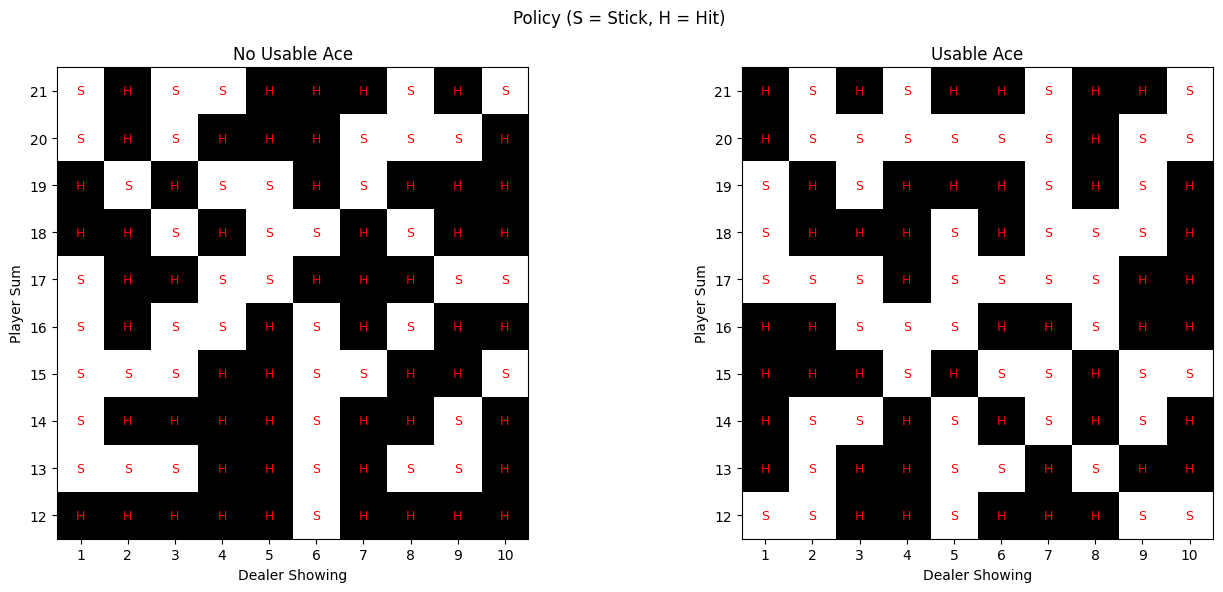

In [16]:
def plot_policy(policy):
    """
    Plots the learned policy as two heatmaps: with and without usable ace.
    """
    # Map strings to integers
    policy = {
        state: 1 if action in ['sticks', 1, 'stick', 'S'] else 0
        for state, action in policy.items()
    }

    player_sums = np.arange(12, 22)  # rows (Y-axis)
    dealer_cards = np.arange(1, 11)  # columns (X-axis)
    
    policy_usable_ace = np.zeros((len(player_sums), len(dealer_cards)))
    policy_no_usable_ace = np.zeros((len(player_sums), len(dealer_cards)))

    for i, player_sum in enumerate(player_sums):
        for j, dealer_card in enumerate(dealer_cards):
            state_with_ace = (player_sum, dealer_card, True)
            state_without_ace = (player_sum, dealer_card, False)

            policy_usable_ace[i, j] = policy.get(state_with_ace, 0)  # default hit
            policy_no_usable_ace[i, j] = policy.get(state_without_ace, 0)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for ax, data, title in zip(
        axes,
        [policy_no_usable_ace, policy_usable_ace],
        ['No Usable Ace', 'Usable Ace']
    ):
        im = ax.imshow(data, cmap='gray', origin='lower')
        ax.set_xticks(np.arange(len(dealer_cards)))
        ax.set_xticklabels(dealer_cards)
        ax.set_yticks(np.arange(len(player_sums)))
        ax.set_yticklabels(player_sums)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_title(title)

        # Add action annotations (S = stick, H = hit)
        for i in range(len(player_sums)):
            for j in range(len(dealer_cards)):
                action = 'S' if data[i, j] == 1 else 'H'
                ax.text(j, i, action, ha='center', va='center', color='red', fontsize=9)

    plt.suptitle('Policy (S = Stick, H = Hit)')
    plt.tight_layout()
    plt.show()

plot_policy(policy=opt_policy)